In [ ]:
# authenticate and connect to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV, train_test_split, cross_validate
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier

from scipy.stats import randint, uniform
import xgboost as xgb



# Feature Engineering

In [ ]:
csv_path = "/content/drive/MyDrive/ML_in_applied_settings/dataset/kickstarter_face_detection.csv"
df = pd.read_csv(csv_path)
df['goal_log'] = np.log(df['goal']) # log transform goal due to right-skewness
df.head()



,id,name,blurb,state,goal,parent_category,sub_category,country,city,currency,project_url,reward_url,photo_url,creation_date,create_to_launch,create_to_deadline,launch_to_deadline,is_face_retinaface,is_face_opencv,goal_log
0,1220845720,KYON:The pet collar re-invented,KYON is the thinnest GPS pet tracker collar to...,successful,75000.0,Technology,Wearables,Greece,Athens,USD,https://www.kickstarter.com/projects/kyontrack...,https://www.kickstarter.com/projects/kyontrack...,https://ksr-ugc.imgix.net/assets/012/360/904/3...,2016-01-22 16:44:55,53.9,113.9,60.0,0,0,11.225243
1,761295303,Walker: Eyewear for Discovery Experiences whil...,Make your everyday walk smarter and more fun w...,successful,115000.0,Technology,Wearables,United States,Sunnyvale,USD,https://www.kickstarter.com/projects/telepathy...,https://www.kickstarter.com/projects/telepathy...,https://ksr-ugc.imgix.net/assets/012/379/192/9...,2016-02-12 06:06:48,32.5,65.8,33.4,0,0,11.652687
2,2042355245,"iBackPack 2.0 - 4G MiFI, HiTech Batteries - Sm...","iBackPack 2.0 - 3G/4G Wi-Fi/Mi-Fi, Bluetooth ...",successful,50000.0,Technology,Wearables,United States,Austin,USD,https://www.kickstarter.com/projects/ibackpack...,https://www.kickstarter.com/projects/ibackpack...,https://ksr-ugc.imgix.net/assets/012/233/312/8...,2015-08-24 20:17:10,197.7,232.6,35.0,0,0,10.819778
3,1252795414,"EZC Smartlight ""The Smarter Way To Ride""",A rider worn tail light brake light. Adheres t...,successful,400.0,Technology,Wearables,Canada,Peterborough,CAD,https://www.kickstarter.com/projects/144329107...,https://www.kickstarter.com/projects/144329107...,https://ksr-ugc.imgix.net/assets/012/396/918/0...,2016-03-03 19:17:23,4.7,39.7,35.0,0,1,5.991465
4,381701864,Knuckle Lights: Rechargeable,The first and only lights designed to be worn ...,successful,15000.0,Technology,Wearables,United States,West Linn,USD,https://www.kickstarter.com/projects/knuckleli...,https://www.kickstarter.com/projects/knuckleli...,https://ksr-ugc.imgix.net/assets/012/354/571/9...,2016-01-15 05:36:01,49.8,79.7,30.0,0,0,9.615805


Log Transformation of goal results in normal distribution

<ipython-input-4-662a6eee7a2f>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df['goal_log'], kde=False, color='green', bins=10)


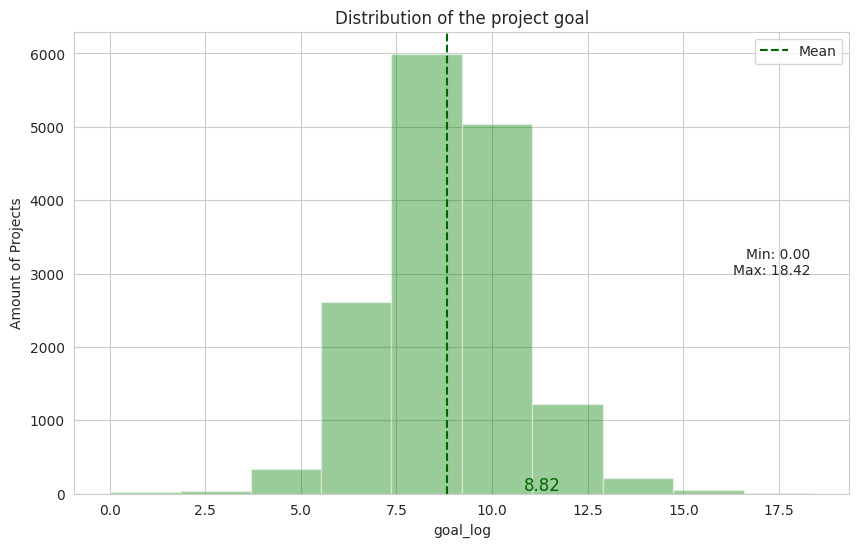

In [ ]:

sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))

ax = sns.distplot(df['goal_log'], kde=False, color='green', bins=10)

plt.title('Distribution of the project goal')
ax.set_ylabel('Amount of Projects')

mean_val = df['goal_log'].mean()
data_min = df['goal_log'].min()
data_max = df['goal_log'].max()

ax.axvline(mean_val, color='darkgreen', linestyle='--', label='Mean')

ax.text(mean_val+2, 50, f"{mean_val:.2f}", fontsize=12, color='darkgreen')

plt.text(0.95, 0.5, f"Min: {data_min:.2f}\nMax: {data_max:.2f}", transform=plt.gca().transAxes, ha='right', va='center')

plt.legend()

plt.show()

In [ ]:
features = df[['state', 'goal_log','parent_category', 'sub_category', 'country', 'city', 'currency', 'creation_date', 'create_to_launch', 'create_to_deadline', 'launch_to_deadline', 'is_face_retinaface', 'is_face_opencv']].copy()

# Convert the 'creation_date' column to datetime format
features['creation_date'] = pd.to_datetime(features['creation_date'])

# Extract the month from the 'creation_date' column
features['month'] = features['creation_date'].apply(lambda x: x.month)

# Mapping of sub_category
features['sub_category_og'] = features['sub_category'].copy()

# Label encode the categorical variables
cat_vars = ['parent_category', 'sub_category', 'country', 'city', 'currency']
le = LabelEncoder()
for var in cat_vars:
    features[var] = le.fit_transform(features[var].astype('str'))

mapping = features.copy()

sub_category_mapping = dict(zip(mapping['sub_category'], mapping['sub_category_og'])) # used to decode the labels later on

# prepare our y target and x feature matrix
y = features['state'].copy()
y = y.map({'successful': 1, 'failed': 0})
features = features.drop(['state', 'creation_date', 'sub_category_og'], axis=1)
X = features.copy()


# Exploratory Model

Exemplary examination of the accuracy volatility in single folds

In [ ]:
X_explore = features[['goal_log', 'is_face_retinaface']]
        
clf = RandomForestClassifier()
scores = cross_validate(clf, X_explore, y, cv=10)['test_score']
accuracy = np.mean(scores)
print(accuracy)
print(scores)


0.6616588445376756
[0.5492595  0.69993561 0.80553767 0.69136598 0.60889175 0.48904639
 0.65141753 0.76353093 0.73453608 0.62306701]


# Functions

In [ ]:
# helper function to initialize the corresponding model

def get_classifier(model):
  if model == 'rf':
    classifier = RandomForestClassifier()
    return classifier
  elif model == 'logreg':
    classifier = LogisticRegression(max_iter=10000)
    return classifier
  elif model == 'xgb':
    classifier = xgb.XGBClassifier()
  elif model == 'nn':
    classifier =  MLPClassifier(hidden_layer_sizes = (100,), 
                                activation = 'relu', 
                                solver = 'adam', 
                                alpha = 0.0001,
                                learning_rate_init = 0.001, 
                                max_iter=500)

    return classifier

# helper function to initialize the corresponding model with new parameters from hyperparameter tuning
def get_classifier_params(model, best_params):
  if model == 'rf':
    classifier = RandomForestClassifier(**best_params)
    return classifier
  elif model == 'logreg':
    classifier = LogisticRegression(max_iter=10000)
    return classifier
  elif model == 'xgb':
    classifier = xgb.XGBClassifier(**best_params)
  elif model == 'nn':
    classifier =  MLPClassifier(**best_params, max_iter=500)

    return classifier

# forward selection with max 5 features and 5-fold cross validation
def forward_selection(features, target, model):
    best_subset = []
    best_accuracy = 0.0

    remaining_features = list(range(len(features.columns))) # every column as integer index

    # until we receive the best feature subset with <5 features
    while len(best_subset) < 5:
        accuracy_list = []
        subset_list = []

        # 9 = RetinaFace, 10 = OpenCV - remove the other one if it is selected into best subset
        # 6 and 7 are highly correlated as they are create_to_deadline and create_to_launch and only one can stay in the best subset
        # check for each addition of the features on the selected model the accuracy using 5-fold cross validation and choose the best feature to add in each iteration

        for feature in remaining_features:
            if (9 in best_subset) & (10 in remaining_features):
              remaining_features.remove(10)
            if (10 in best_subset) & (9 in remaining_features):
              remaining_features.remove(9)
            if (6 in best_subset) & (7 in remaining_features):
              remaining_features.remove(7)
            if (7 in best_subset) & (6 in remaining_features):
              remaining_features.remove(6)
            subset = best_subset + [feature]
            X = np.array(features.iloc[:, subset])
            y = np.array(target)

            classifier = get_classifier(model)
            
            accuracy = np.mean(cross_val_score(classifier, X, y, cv=5))

            accuracy_list.append(accuracy)
            subset_list.append(subset)

        # best subset of that iteration (e.g. 2 features) is chosen from the accuracy_list containing all feature subsets of that iteration

        best_index = np.argmax(accuracy_list)
        
        # stop condition when accuracy decreases through addition of feature

        if best_accuracy < accuracy_list[best_index]:
          best_accuracy = accuracy_list[best_index]
          best_subset = subset_list[best_index]
        else:
          break

        remaining_features.remove(best_subset[-1])

    print("Best subset of features:", [features.columns[index] for index in best_subset], "Subset Accuracy: {:.3f}".format(best_accuracy))

    return best_subset

# print out performance metrics

def performance_measures():
  # Calculate and print the mean accuracy across all outer folds
  mean_accuracy = sum(outer_scores) / len(outer_scores)
  print("Mean Accuracy: {:.3f}".format(mean_accuracy))

  # Compute the confusion matrix
  confusion = confusion_matrix(all_y_true, all_y_pred)

  # Calculate precision, sensitivity, and specificity
  tn, fp, fn, tp = confusion.ravel()
  precision = tp / (tp + fp)
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)

  print("Mean Precision: {:.3f}".format(precision))
  print("Mean Sensitivity: {:.3f}".format(sensitivity))
  print("Mean Specificity: {:.3f}".format(specificity))
  print("Mean Retinaface improvement:", sum(retinaface_improvement)/max(len(retinaface_improvement), 0.1)*100, "%")
  print("Mean OpenCV improvement:", sum(opencv_improvement)/max(len(opencv_improvement), 0.1)*100, "%")
  print("Mean Retinaface over OpenCV improvement:", sum(retinaface_compare)/max(len(retinaface_compare), 0.1)*100, "%")


# helper function that generates model evaluation with and without the face detection variable included and compares the two libraries
# is only called when the face detection variable is actually part of the best feature subset
# first code block for RetinaFace, second code block for OpenCV

def compare_models_with_varying_facedetectors(selected_features, model):
      if 9 in selected_features:
          classifier = get_classifier_params(model, best_params)

          # estimate accuracy decrease without RetinaFace

          features_without_retinaface = selected_features.copy()
          features_without_retinaface.remove(9)
          classifier.fit(X_train.iloc[:, features_without_retinaface], y_train)

          accuracy_retinaface_improvement = classifier.score(X_test.iloc[:, features_without_retinaface], y_test)
          retinaface_improvement.append(accuracy-accuracy_retinaface_improvement)

          # estimate accuracy decrease with OpenCV instead of Retinaface

          classifier = get_classifier_params(model, best_params)

          features_opencv_replaces_retinaface = selected_features.copy()
          features_opencv_replaces_retinaface.remove(9)
          features_opencv_replaces_retinaface.append(10)
          classifier.fit(X_train.iloc[:, features_opencv_replaces_retinaface], y_train)

          accuracy_retinaface_compare = classifier.score(X_test.iloc[:, features_opencv_replaces_retinaface], y_test)
          retinaface_compare.append(accuracy-accuracy_retinaface_compare)
      else: 
        if 10 in selected_features:
          classifier = get_classifier_params(model, best_params)

          # estimate accuracy decrease without OpenCV

          features_without_opencv = selected_features.copy()
          features_without_opencv.remove(10)
          classifier.fit(X_train.iloc[:, features_without_opencv], y_train)

          accuracy_opencv_improvement = classifier.score(X_test.iloc[:, features_without_opencv], y_test)
          opencv_improvement.append(accuracy-accuracy_opencv_improvement)

          # estimate accuracy decrease with Retinaface instead of OpenCV

          classifier = get_classifier_params(model, best_params)

          features_retinaface_replaces_opencv = selected_features.copy()
          features_retinaface_replaces_opencv.remove(10)
          features_retinaface_replaces_opencv.append(9)
          classifier.fit(X_train.iloc[:, features_retinaface_replaces_opencv], y_train)

          accuracy_opencv_compare = classifier.score(X_test.iloc[:, features_retinaface_replaces_opencv], y_test)
          retinaface_compare.append(accuracy_opencv_compare - accuracy)

# calculate performance metrics per sub category when evaluating a validation set - accuracy here is not as robust as the cross validated one, therefore neglected
def performance_per_sub_category(y_pred):

# Append predicted values as a column to the test dataset
  test_df = X_test.copy()
  test_df['actual'] = y_test.copy()
  test_df['predicted'] = y_pred.copy()

  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy)

  # Calculate confusion matrix
  confusion = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = confusion.ravel()

  # Calculate specificity
  specificity = tn / (tn + fp)
  print("Specificity:", specificity)

  # Calculate sensitivity (recall)
  sensitivity = recall_score(y_test, y_pred)
  print("Sensitivity:", sensitivity)

  # Calculate precision
  precision = precision_score(y_test, y_pred)
  print("Precision:", precision)

  grouped_metrics = test_df.groupby('sub_category').apply(lambda x: pd.Series({
      'accuracy': accuracy_score(x['actual'], x['predicted']),
      'precision': precision_score(x['actual'], x['predicted']),
      'recall': recall_score(x['actual'], x['predicted']),
  }))

  grouped_metrics = grouped_metrics.reset_index()
  grouped_metrics['sub_category'] = grouped_metrics['sub_category'].map(sub_category_mapping)

  # Print the grouped metrics
  print(grouped_metrics.sort_values(by="accuracy", ascending = False))

# Logistic Regression

In [ ]:
# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform outer cross-validation
outer_scores = []
all_y_true = []
all_y_pred = []
retinaface_improvement = []
opencv_improvement = []
retinaface_compare = []
best_params = 0

for train_indices, test_indices in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_indices, :], X.iloc[test_indices, :]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    # Call the forward_selection function on the training data of the outer fold -> inner cv happens here
    selected_features = forward_selection(X_train, y_train, "logreg")

    # Train the model using the selected features

    classifier = LogisticRegression(max_iter=10000)
    classifier.fit(X_train.iloc[:, selected_features], y_train)

    y_pred = classifier.predict(X_test.iloc[:, selected_features])
    accuracy = accuracy_score(y_test, y_pred)
    outer_scores.append(accuracy)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # compare the impact in each fold that has face detection of either OpenCV or Retinaface, by measuring the reduced accuracy when removing and the accuracy improvement over the other face detection library

    compare_models_with_varying_facedetectors(selected_features, "logreg")   

performance_measures()

Best subset of features: ['sub_category', 'goal_log', 'is_face_retinaface', 'launch_to_deadline'] Subset Accuracy: 0.691
Best subset of features: ['sub_category', 'goal_log'] Subset Accuracy: 0.696
Best subset of features: ['sub_category', 'goal_log'] Subset Accuracy: 0.694
Best subset of features: ['sub_category', 'goal_log', 'is_face_retinaface'] Subset Accuracy: 0.692
Best subset of features: ['sub_category', 'goal_log'] Subset Accuracy: 0.694
Best subset of features: ['sub_category', 'goal_log'] Subset Accuracy: 0.694
Best subset of features: ['sub_category', 'goal_log'] Subset Accuracy: 0.693
Best subset of features: ['sub_category', 'goal_log', 'currency', 'launch_to_deadline'] Subset Accuracy: 0.696
Best subset of features: ['sub_category', 'goal_log'] Subset Accuracy: 0.694
Best subset of features: ['sub_category', 'goal_log'] Subset Accuracy: 0.693
Mean Accuracy: 0.711
Mean Precision: 0.731
Mean Sensitivity: 0.764
Mean Specificity: 0.645
Mean Retinaface improvement: 0.67631820

Evaluate the results only in terms of sub categories of a fully trained model on a validation set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

selected_features = forward_selection(X_train, y_train, "logreg")

classifier = LogisticRegression(max_iter=10000)
classifier.fit(X_train.iloc[:, selected_features], y_train)

y_pred = classifier.predict(X_test.iloc[:, selected_features])

performance_per_sub_category(y_pred)

Best subset of features: ['sub_category', 'goal_log', 'parent_category'] Subset Accuracy: 0.715
Accuracy: 0.7005795235028976
Specificity: 0.6637554585152838
Sensitivity: 0.7297921478060047
Precision: 0.7323290845886443
         sub_category  accuracy  precision    recall
13               Kids  1.000000   1.000000  1.000000
9             Hip-Hop  1.000000   1.000000  1.000000
19                R&B  1.000000   1.000000  1.000000
18                Pop  1.000000   1.000000  1.000000
15              Music  1.000000   1.000000  1.000000
14              Metal  1.000000   1.000000  1.000000
1            Chiptune  1.000000   1.000000  1.000000
12               Jazz  1.000000   1.000000  1.000000
11         Indie Rock  1.000000   1.000000  1.000000
7               Faith  1.000000   1.000000  1.000000
5    Electronic Music  1.000000   1.000000  1.000000
4      Country & Folk  1.000000   1.000000  1.000000
20               Rock  0.888889   1.000000  0.888889
2     Classical Music  0.844000   0.844

# Random Forest


In [ ]:
# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform outer cross-validation
outer_scores = []
all_y_true = []
all_y_pred = []
retinaface_improvement = []
opencv_improvement = []
retinaface_compare = []

for train_indices, test_indices in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_indices, :], X.iloc[test_indices, :]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    # Call the forward_selection function on the training data of the outer fold -> our inner cv happens here
    selected_features = forward_selection(X_train, y_train, "rf")

    # Define the parameter distributions
    param_dist = {
    'n_estimators': randint(10, 100),
    'max_depth': [10, 20, None],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
    }

    # Create the Random Forest model
    classifier = RandomForestClassifier()

    # Run randomized search - change n_iter to change number of random parameter combinations
    search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist,
                                n_iter=50, cv=5)

    # Fit the search object to the data
    search.fit(X_train.iloc[:, selected_features], y_train)

    # Get the best hyperparameters
    best_params = search.best_params_

    # Train the model with the best hyperparameters
    best_model = RandomForestClassifier(**best_params)
    best_model.fit(X_train.iloc[:, selected_features], y_train)

    y_pred = best_model.predict(X_test.iloc[:, selected_features])
    accuracy = accuracy_score(y_test, y_pred)
    outer_scores.append(accuracy)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # compare the impact in each fold that has face detection of either opencv or retinaface, by measuring the reduced accuracy when removing and the accuracy improvement over the other face detection library

    compare_models_with_varying_facedetectors(selected_features, "rf")   

performance_measures()

Best subset of features: ['goal_log', 'is_face_retinaface', 'currency'] Subset Accuracy: 0.660
Best subset of features: ['goal_log', 'is_face_retinaface'] Subset Accuracy: 0.661
Best subset of features: ['goal_log', 'is_face_retinaface', 'currency'] Subset Accuracy: 0.661
Best subset of features: ['goal_log', 'is_face_retinaface'] Subset Accuracy: 0.663
Best subset of features: ['goal_log', 'is_face_retinaface'] Subset Accuracy: 0.663
Best subset of features: ['goal_log', 'is_face_retinaface'] Subset Accuracy: 0.664
Best subset of features: ['goal_log', 'is_face_retinaface', 'currency'] Subset Accuracy: 0.664
Best subset of features: ['goal_log', 'is_face_retinaface', 'currency'] Subset Accuracy: 0.665
Best subset of features: ['goal_log', 'currency', 'is_face_retinaface'] Subset Accuracy: 0.665
Best subset of features: ['goal_log', 'is_face_retinaface', 'currency'] Subset Accuracy: 0.662
Mean Accuracy: 0.680
Mean Precision: 0.682
Mean Sensitivity: 0.797
Mean Specificity: 0.532
Mean Re

Evaluate the results only in terms of sub categories of a fully trained model on a validation set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

selected_features = forward_selection(X_train, y_train, "rf")

# Define the parameter distributions
param_dist = {
'n_estimators': randint(10, 100),
'max_depth': [10, 20, None],
'max_features': ['sqrt'],
'min_samples_split': [2, 5],
'min_samples_leaf': [1, 2],
'bootstrap': [True, False]
}

classifier = RandomForestClassifier()

# Run randomized search - change n_iter to change number of random parameter combinations
search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist,
                            n_iter=50, cv=5)

# Fit the search object to the data
search.fit(X_train.iloc[:, selected_features], y_train)

# Get the best hyperparameters
best_params = search.best_params_

# Train the model with the best hyperparameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train.iloc[:, selected_features], y_train)

y_pred = best_model.predict(X_test.iloc[:, selected_features])

performance_per_sub_category(y_pred)


Best subset of features: ['sub_category', 'goal_log'] Subset Accuracy: 0.715
Accuracy: 0.7224726336123631
Specificity: 0.6200873362445415
Sensitivity: 0.8036951501154734
Precision: 0.7272727272727273
         sub_category  accuracy  precision    recall
13               Kids  1.000000   1.000000  1.000000
9             Hip-Hop  1.000000   1.000000  1.000000
20               Rock  1.000000   1.000000  1.000000
19                R&B  1.000000   1.000000  1.000000
18                Pop  1.000000   1.000000  1.000000
15              Music  1.000000   1.000000  1.000000
14              Metal  1.000000   1.000000  1.000000
12               Jazz  1.000000   1.000000  1.000000
11         Indie Rock  1.000000   1.000000  1.000000
26        World Music  1.000000   1.000000  1.000000
4      Country & Folk  1.000000   1.000000  1.000000
7               Faith  1.000000   1.000000  1.000000
5    Electronic Music  1.000000   1.000000  1.000000
1            Chiptune  0.875000   1.000000  0.875000
25   

# XGBoost

In [ ]:
# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform outer cross-validation
outer_scores = []
all_y_true = []
all_y_pred = []
retinaface_improvement = []
opencv_improvement = []
retinaface_compare = []

for train_indices, test_indices in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_indices, :], X.iloc[test_indices, :]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    # Call the forward_selection function on the training data of the outer fold -> our inner cv happens here
    selected_features = forward_selection(X_train, y_train, "xgb")

    # Define the parameter distributions
    param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.1)
    }

    # Create the XGBoost classifier
    classifier = xgb.XGBClassifier()

    # Run randomized search - change n_iter to change number of random parameter combinations
    search = RandomizedSearchCV(classifier, param_dist, n_iter=50, cv=5)

    # Fit the search object to the data
    search.fit(X_train.iloc[:, selected_features], y_train)

    # Get the best hyperparameters
    best_params = search.best_params_

    # Train the model with the best hyperparameters
    best_model = xgb.XGBClassifier(**best_params)
    best_model.fit(X_train.iloc[:, selected_features], y_train)

    y_pred = best_model.predict(X_test.iloc[:, selected_features])
    accuracy = accuracy_score(y_test, y_pred)
    outer_scores.append(accuracy)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # compare the impact in each fold that has face detection of either opencv or retinaface, by measuring the reduced accuracy when removing and the accuracy improvement over the other face detection library

    compare_models_with_varying_facedetectors(selected_features, "xgb")   

performance_measures()

Best subset of features: ['goal_log', 'is_face_retinaface', 'currency', 'launch_to_deadline', 'create_to_deadline'] Subset Accuracy: 0.691
Best subset of features: ['goal_log', 'is_face_retinaface', 'currency', 'launch_to_deadline', 'create_to_deadline'] Subset Accuracy: 0.691
Best subset of features: ['goal_log', 'is_face_retinaface', 'currency', 'city', 'launch_to_deadline'] Subset Accuracy: 0.689
Best subset of features: ['goal_log', 'currency', 'launch_to_deadline', 'is_face_retinaface', 'create_to_launch'] Subset Accuracy: 0.693
Best subset of features: ['goal_log', 'is_face_retinaface', 'currency', 'launch_to_deadline', 'city'] Subset Accuracy: 0.694
Best subset of features: ['goal_log', 'is_face_retinaface', 'launch_to_deadline', 'city', 'create_to_launch'] Subset Accuracy: 0.695
Best subset of features: ['goal_log', 'currency', 'launch_to_deadline', 'create_to_deadline', 'is_face_retinaface'] Subset Accuracy: 0.693
Best subset of features: ['goal_log', 'currency', 'launch_to_de

Evaluate the results only in terms of sub categories of a fully trained model on a validation set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

selected_features = forward_selection(X_train, y_train, "xgb")

# Define the parameter distributions
param_dist = {
'n_estimators': randint(100, 500),
'max_depth': randint(3, 10),
'learning_rate': uniform(0.01, 0.1)
}

# Create the XGBoost classifier
classifier = xgb.XGBClassifier()

# Run randomized search - change n_iter to change number of random parameter combinations
search = RandomizedSearchCV(classifier, param_dist, n_iter=50, cv=5)

# Fit the search object to the data
search.fit(X_train.iloc[:, selected_features], y_train)

# Get the best hyperparameters
best_params = search.best_params_

# Train the model with the best hyperparameters
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train.iloc[:, selected_features], y_train)

y_pred = best_model.predict(X_test.iloc[:, selected_features])

performance_per_sub_category(y_pred)


Best subset of features: ['sub_category', 'goal_log', 'city', 'launch_to_deadline', 'is_face_opencv'] Subset Accuracy: 0.760
Accuracy: 0.7707662588538313
Specificity: 0.6914119359534207
Sensitivity: 0.8337182448036952
Precision: 0.7730192719486081
         sub_category  accuracy  precision    recall
13               Kids  1.000000   1.000000  1.000000
9             Hip-Hop  1.000000   1.000000  1.000000
20               Rock  1.000000   1.000000  1.000000
19                R&B  1.000000   1.000000  1.000000
18                Pop  1.000000   1.000000  1.000000
15              Music  1.000000   1.000000  1.000000
14              Metal  1.000000   1.000000  1.000000
12               Jazz  1.000000   1.000000  1.000000
11         Indie Rock  1.000000   1.000000  1.000000
26        World Music  1.000000   1.000000  1.000000
4      Country & Folk  1.000000   1.000000  1.000000
7               Faith  1.000000   1.000000  1.000000
5    Electronic Music  1.000000   1.000000  1.000000
3         

# Neural Network

In [ ]:
# Define the outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform outer cross-validation
outer_scores = []
all_y_true = []
all_y_pred = []
retinaface_improvement = []
opencv_improvement = []
retinaface_compare = []

for train_indices, test_indices in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_indices, :].copy() , X.iloc[test_indices, :].copy() 
    y_train, y_test = y.iloc[train_indices].copy() , y.iloc[test_indices].copy() 

    numeric_features = ['goal_log', 'create_to_launch', 'launch_to_deadline', 'create_to_deadline']

    scaler = StandardScaler()
    X_train[numeric_features] = scaler.fit_transform(X_train.loc[:, numeric_features])
    X_test[numeric_features] = scaler.transform(X_test.loc[:, numeric_features])

    # Call the forward_selection function on the training data of the outer fold -> our inner cv happens here
    selected_features = forward_selection(X_train, y_train, "nn")

    # Define the parameter distributions

    param_dist = {
    'hidden_layer_sizes': [(100,), (50,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    }

    # Create the MLP Neural Network classifier
    classifier =  MLPClassifier(max_iter=500)

    # Run randomized search - change n_iter to change number of random parameter combinations
    search = RandomizedSearchCV(classifier, param_distributions=param_dist, cv=5, n_iter=10)

    # Fit the search object to the data
    search.fit(X_train.iloc[:, selected_features], y_train)

    # Get the best hyperparameters
    best_params = search.best_params_

    # Train the model with the best hyperparameters
    best_model =MLPClassifier(**best_params)
    best_model.fit(X_train.iloc[:, selected_features], y_train)

    y_pred = best_model.predict(X_test.iloc[:, selected_features])
    accuracy = accuracy_score(y_test, y_pred)
    outer_scores.append(accuracy)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # compare the impact in each fold that has face detection of either opencv or retinaface, by measuring the reduced accuracy when removing and the accuracy improvement over the other face detection library

    compare_models_with_varying_facedetectors(selected_features, "nn")   

performance_measures()

Best subset of features: ['sub_category', 'is_face_opencv'] Subset Accuracy: 0.680
Best subset of features: ['sub_category'] Subset Accuracy: 0.675
Best subset of features: ['sub_category', 'month'] Subset Accuracy: 0.679


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best subset of features: ['goal_log', 'is_face_retinaface', 'create_to_launch', 'launch_to_deadline', 'currency'] Subset Accuracy: 0.690


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best subset of features: ['sub_category'] Subset Accuracy: 0.675
Best subset of features: ['sub_category'] Subset Accuracy: 0.666
Best subset of features: ['sub_category'] Subset Accuracy: 0.684
Best subset of features: ['sub_category'] Subset Accuracy: 0.685
Best subset of features: ['goal_log', 'create_to_launch', 'is_face_retinaface', 'currency', 'launch_to_deadline'] Subset Accuracy: 0.692


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best subset of features: ['sub_category', 'is_face_opencv'] Subset Accuracy: 0.691
Mean Accuracy: 0.685
Mean Precision: 0.718
Mean Sensitivity: 0.718
Mean Specificity: 0.644
Mean Retinaface improvement: 1.514175257731959 %
Mean OpenCV improvement: -0.8697623820872136 %
Mean Retinaface over OpenCV improvement: 1.2725722910761323 %


Evaluate the results only in terms of sub categories of a fully trained model on a validation set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

numeric_features = ['goal_log', 'create_to_launch', 'launch_to_deadline', 'create_to_deadline']

scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train.loc[:, numeric_features])
X_test[numeric_features] = scaler.transform(X_test.loc[:, numeric_features])

selected_features = forward_selection(X_train, y_train, "nn")

# Define the parameter distributions
param_dist = {
'hidden_layer_sizes': [(100,), (50,)],
'activation': ['relu', 'tanh'],
'solver': ['adam', 'sgd'],
'alpha': [0.0001, 0.001, 0.01],
}

# Create the MLP Neural Network classifier
classifier =  MLPClassifier(max_iter=500)

# Run randomized search - change n_iter to change number of random parameter combinations
search = RandomizedSearchCV(classifier, param_distributions=param_dist, cv=5, n_iter=10)

# Fit the search object to the data
search.fit(X_train.iloc[:, selected_features], y_train)

# Get the best hyperparameters
best_params = search.best_params_

# Train the model with the best hyperparameters
best_model =MLPClassifier(**best_params)
best_model.fit(X_train.iloc[:, selected_features], y_train)

y_pred = best_model.predict(X_test.iloc[:, selected_features])

performance_per_sub_category(y_pred)




   

Best subset of features: ['parent_category', 'goal_log', 'create_to_launch', 'sub_category', 'is_face_retinaface'] Subset Accuracy: 0.736
Accuracy: 0.7186091435930457
Specificity: 0.6957787481804949
Sensitivity: 0.7367205542725174
Precision: 0.7532467532467533
         sub_category  accuracy  precision    recall
13               Kids  1.000000   1.000000  1.000000
11         Indie Rock  1.000000   1.000000  1.000000
20               Rock  1.000000   1.000000  1.000000
19                R&B  1.000000   1.000000  1.000000
18                Pop  1.000000   1.000000  1.000000
15              Music  1.000000   1.000000  1.000000
14              Metal  1.000000   1.000000  1.000000
1            Chiptune  1.000000   1.000000  1.000000
12               Jazz  1.000000   1.000000  1.000000
26        World Music  1.000000   1.000000  1.000000
4      Country & Folk  1.000000   1.000000  1.000000
7               Faith  1.000000   1.000000  1.000000
5    Electronic Music  1.000000   1.000000  1.0000